# Experiments comparing the corpora FakeWhatsApp.Br and FakeTweet.Br
Are WhatsApp texts so unique that a corpus of WhatsApp texts is needed? Our hypothesis is that WhatsApp texts have a linguistic pattern that differs from other social networks, such as Twitter, Facebook, etc., due to the purpose of each platform.

We can mention, for example, that WhatsApp has a stronger dialogical nature, texts are generally short, there is an extensive use of emojis, media (images, audios, videos) and a profile of different use, due to data packages that allow unlimited use of the platform.

Therefore, a misinformation detection model trained with texts from other media would not perform well in WhatsApp texts. In this Notebook, we try to confirm this hypothesis, comparing it with the only known corpus up to the moment of Fake News on PT-BR from Twitter. Twitter is a platform whose texts are limited in size, possibly resembling many WhatsApp texts.

Corpus FakeTweet.Br made available on https://github.com/prc992/FakeTweet.Br

CORDEIRO, P.; Pinheiro, V.. Um Corpus de Notícias Falsas do Twitter e Verificacão Automática de Rumores em Língua Portuguesa. In: STIL 19 - Symposium in Information and Human Language Technology, 2019, Salvador. Proceedings if the STIL 19 - Symposium in Information and Human Language Technology, 2019. v. 1. p. 219-228.<br>
Homepage: http://comissoes.sbc.org.br/ce-pln/stil2019/proceedings-stil-2019-Final-Publicacao.pdf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import getTestMetrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from scipy.spatial import distance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE 

%matplotlib inline
sns.set(style="darkgrid")

In [3]:
#twitter concat train and test
url_twitter = 'https://raw.githubusercontent.com/prc992/FakeTweet.Br/master/FakeTweetBr.csv'
twitter = pd.read_csv(url_twitter)
url_twitter_test = 'https://raw.githubusercontent.com/prc992/FakeTweet.Br/master/FakeTweetBr-Test.csv'
twitter_test = pd.read_csv(url_twitter_test)
twitter_test['classificacao'] = [t.lower() for t in twitter_test['classificacao']]
twitter = pd.concat([twitter,twitter_test])

base = 2018
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
whatsapp = pd.read_csv(filepath)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
twitter.tail()

,Unnamed: 0,id,subject,text,classificacao,date,retweets,favorites,permalink
15,691,4.210000e+17,navio msc lixo,Flagra: Navio da MSC (Mediterranean Shipping C...,fake,2014-01-09 12:03,0,0,https://twitter.com/deguchijr/status/421296141...
16,706,4.200000e+17,navio msc lixo,Coisa feia!!! Vídeo mostra navio MSC jogando l...,fake,2014-01-06 0:17,0,0,https://twitter.com/chrica2010/status/42003145...
17,779,1.120000e+18,gustave notre dame,O pintor Gustave Freipont teria previsto o inc...,true,2019-04-19 17:06,0,0,https://twitter.com/Arq_MauTavaresS/status/111...
18,797,1.120000e+18,gustave notre dame,Chegou aqui a pergunta sobre a pintura de um t...,true,2019-04-18 14:54,1,51,https://twitter.com/caduzaodamassa/status/1118...
19,815,1.120000e+18,gustave notre dame,"Essa pintura de Gustave Freipont, de 1924, se ...",fake,2019-04-17 23:26,0,0,https://twitter.com/keila_fr/status/1118702265...


In [5]:
#examples
print('WhatsApp examples')
print()
print('misinformation')
print(list(whatsapp[whatsapp['misinformation']==1]['text'].sample(n=3, random_state=42)))
print()
print('non-misinformation')
print(list(whatsapp[whatsapp['misinformation']==0]['text'].sample(n=3, random_state=42)))
print()
print('Twitter examples')
print()
print('fake')
print(list(twitter[twitter['classificacao']=='fake']['text'].sample(n=3, random_state=42)))
print()
print('true')
print(list(twitter[twitter['classificacao']=='true']['text'].sample(n=3, random_state=42)))

WhatsApp examples

misinformation
['_*TSE informa:*_ 7,2 milhões de votos anulados pelas urnas! A diferença de votos que levaria à vitória de Bolsonaro no primeiro turno foi de menos de 2 milhões .\nO TSE tem obrigação de esclarecer os motivos que levaram à anulação de mais de 7,2 milhões de votos que representam 6,2% do total. A anulação só pode acontecer em voto de papel, porque permite rasuras ou ambiguidade.\n\nSe você enviar para apenas 20 contatos em um minuto, o Brasil inteiro vai desmascarar este Bandido. NÃO quebre essa corrente. Os incautos precisam ser esclarecidos antes que seja tarde demais...', 'ABSURDO! 😡😡😡\nUMA PROFESSORA SEGURA O MENINO E OUTRA PASSA O BATOM, \nO MENINO CHORA E IMPLORA PRA NÃO PASSAR , ELAS DEBOCHAM E DÃO RISADA.\nISSO É IDEOLOGIA DE GÊNERO ? \nCOMPARTILHE SE NÃO QUER ESSE ABUSO COM NOSSAS CRIANÇAS !', 'Olha o que o candidato à reeleição ao Senado Federal, que foi do PT, PDT e hoje está no  PPS, ( todos partidos de Esquerda), CRISTOVAM BUARQUE fez dent

# Distribuitions

In [6]:
twitter['words'] = [len(s.split()) for s in twitter['text']]
twitter['chars'] = [len(s) for s in twitter['text']]

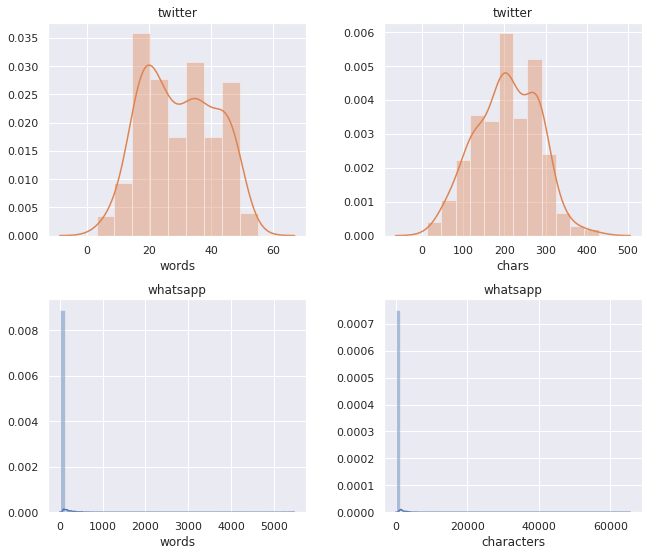

In [7]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.title('twitter')
sns.distplot(twitter['words'], kde = True, color = 'C1')

plt.subplot(222)
plt.title('twitter')
sns.distplot(twitter['chars'], kde = True, color = 'C1')

plt.subplot(223)
plt.title('whatsapp')
sns.distplot(whatsapp['words'], kde = True, color = 'C0')

plt.subplot(224)
plt.title('whatsapp')
sns.distplot(whatsapp['characters'], kde = True, color = 'C0')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.95, 
                    wspace=0.3, 
                    hspace=0.3)

plt.show()

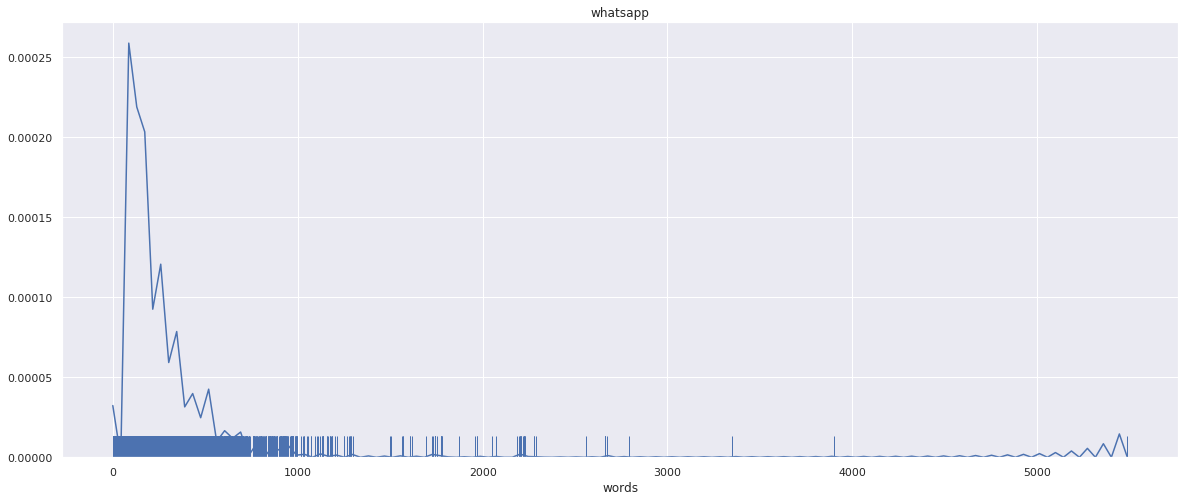

In [8]:
plt.figure(figsize=(20, 8))
plt.title('whatsapp')
sns.distplot(whatsapp[whatsapp['midia'] == 0]['words'], hist = False, kde = True, rug = True)
plt.show()

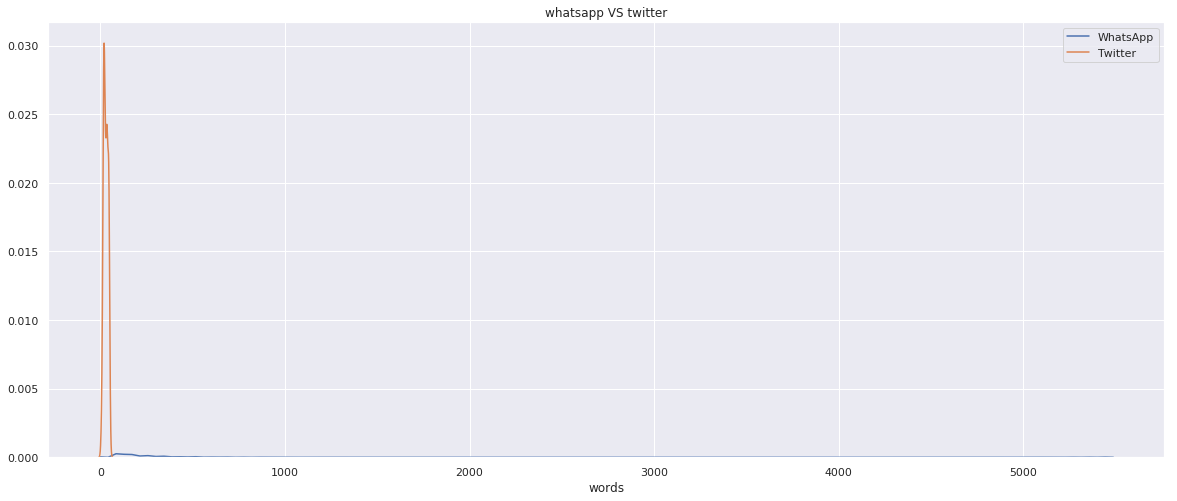

In [9]:
plt.figure(figsize=(20, 8))
plt.title('whatsapp VS twitter')
sns.distplot(whatsapp[whatsapp['midia'] == 0]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

In [10]:
whatsapp['class'] = ['fake' if s == 1 else 'non-fake' for s in whatsapp['misinformation']]

### Distribuitions by class

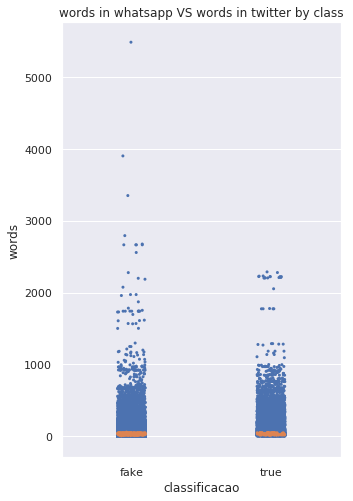

In [11]:
plt.figure(figsize=(5,8))
plt.title('words in whatsapp VS words in twitter by class')
sns.stripplot(y="words", x = 'class', size = 3, color = 'C0', data=whatsapp)
sns.stripplot(y="words", x = 'classificacao', data=twitter, size = 3, color = 'C1')
plt.show()

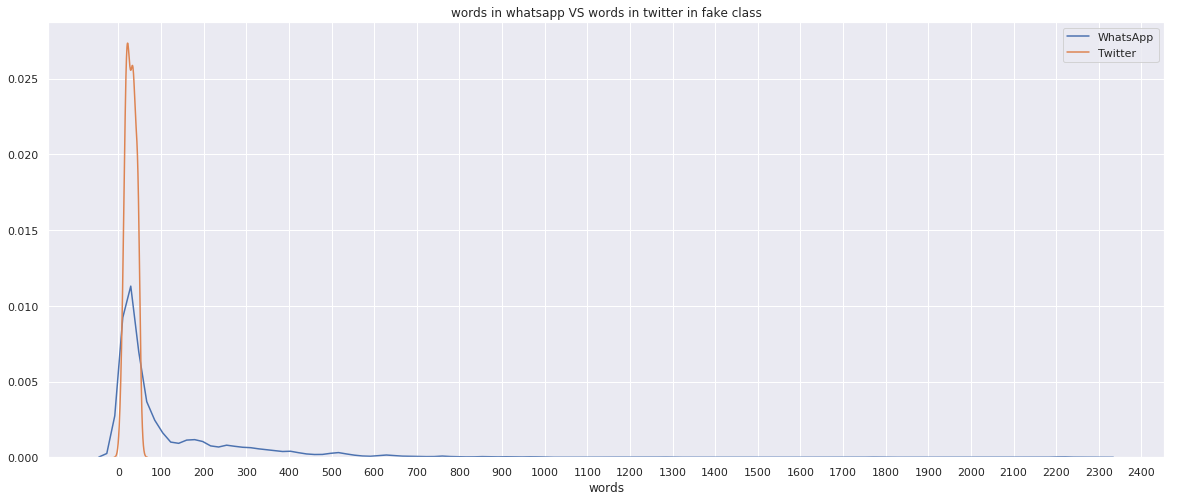

In [12]:
plt.figure(figsize=(20, 8))
plt.title('words in whatsapp VS words in twitter in fake class')
plt.xticks(np.arange(0, 2500, 100))
sns.distplot(whatsapp[(whatsapp['midia'] == 0) & (whatsapp['misinformation']==1)]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='fake']['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

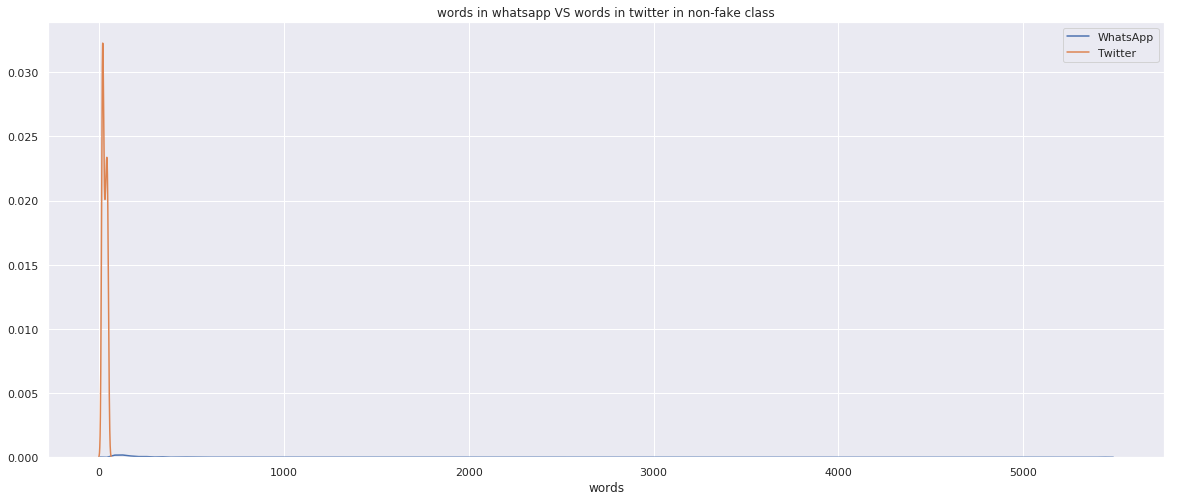

In [13]:
plt.figure(figsize=(20, 8))
plt.title('words in whatsapp VS words in twitter in non-fake class')
#plt.xticks(np.arange(0, 2500, 100))
sns.distplot(whatsapp[(whatsapp['midia'] == 0) & (whatsapp['misinformation']==0)]['words'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='true']['words'], hist = False, kde = True, label = 'Twitter')
plt.show()

# Vocabulary

In [14]:
twi_set = set(' '.join(list(twitter['text'])).split())
print('Twitter')
print('Size of vocabulary:', len(twi_set))
print('Unique documents:', len(twitter['text'].unique()))
print()

wpp_set = set(' '.join(list(whatsapp['text'])).split())
print('WhatsApp')
print('Size of vocabulary:', len(wpp_set))
print('Unique documents:', len(whatsapp['text'].unique()))
print()

print('Vocab')
print('Intersection:',len(twi_set.intersection(wpp_set)))
twi_perc = len(twi_set.intersection(wpp_set))/len(twi_set)
print('Percentage in twitter: %0.2f' % twi_perc)
wpp_perc = len(twi_set.intersection(wpp_set))/len(wpp_set)
print('Percentage in whatsapp: %0.2f' % wpp_perc)
print('Diference (whatsapp - twitter):',len(wpp_set.difference(twi_set)))



Twitter
Size of vocabulary: 3279
Unique documents: 298

WhatsApp
Size of vocabulary: 205554
Unique documents: 114445

Vocab
Intersection: 2374
Percentage in twitter: 0.72
Percentage in whatsapp: 0.01
Diference (whatsapp - twitter): 203180


# Similar documents

In [15]:
#TF-IDF
vectorizer = TfidfVectorizer()
vectorizer.fit(whatsapp['text'])

wpp_tfid = vectorizer.transform(whatsapp['text'])
twitter_tfid = vectorizer.transform(twitter['text'])

#calculate cosine distance
cosine_similarities = linear_kernel(twitter_tfid, wpp_tfid)
cosine_similarities.shape

#max similaritie for each document
max_sim = cosine_similarities.max(axis = 1)
max_arg = cosine_similarities.argmax(axis = 1)
max_sim.shape

(299,)

No intersection of documents in the corpora


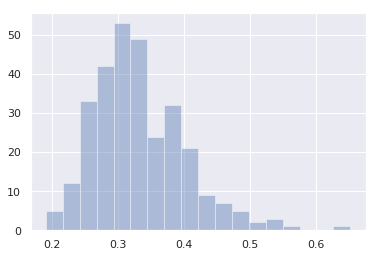

In [16]:
print('No intersection of documents in the corpora')
sns.distplot(max_sim,kde=False)
plt.show()

In [17]:
#document with max similaritie
best_match = [whatsapp.iloc[idx]['text'] for idx in max_arg] 
df_sim = pd.DataFrame({'text_twitter': twitter['text'],
         'best_match':best_match,
         'sim': max_sim})

df_sim[df_sim['sim']>0.6]

,text_twitter,best_match,sim
182,Não é rachadura . É uma junta de dilatação da ...,Hoje! Ponte Rio-Niteroi...,0.651371


# Comparation between models of classification
An model trained with Twitter data can generalize well over WhatsApp data?
We train model with twitter data as proposed in the original paper, using the worst and the best classifiers reported (Logistic Regression and Complement Naive Bayes, respectively). 

In [18]:
#previously separated in train and test by original author
twitter = pd.read_csv(url_twitter)
twitter_test = pd.read_csv(url_twitter_test)
twitter_test['classificacao'] = [t.lower() for t in twitter_test['classificacao']]

Twitter


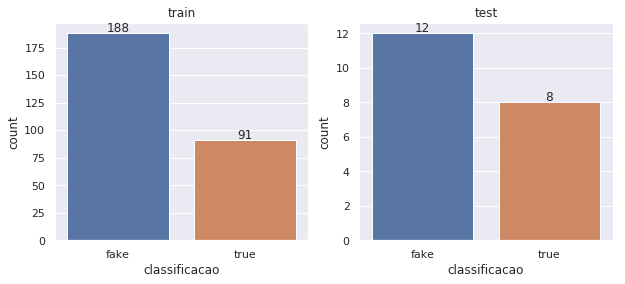

In [19]:
print('Twitter')
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('train')
g = sns.countplot(x='classificacao',data = twitter)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')
    
plt.subplot(122)
plt.title('test')
g = sns.countplot(x='classificacao',data = twitter_test)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

### Scenario 1: training and evaluating with Twitter data

In [20]:
#metrics
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

In [21]:
#targets
y_train = [1 if s == 'fake' else 0 for s in twitter['classificacao']]
y_test = [1 if s == 'fake' else 0 for s in twitter_test['classificacao']]

#tf-idf input
vectorizer = CountVectorizer(ngram_range=(1, 2))
#vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorizer = TfidfVectorizer()
vectorizer.fit(twitter['text'])

X_train = vectorizer.transform(twitter['text'])
X_test = vectorizer.transform(twitter_test['text'])

#normalization
# scaler = StandardScaler(with_mean=False)
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(279, 2411)
(20, 2411)


Logistic Regression unbalanced
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.67      1.00      0.80        12

    accuracy                           0.70        20
   macro avg       0.83      0.62      0.60        20
weighted avg       0.80      0.70      0.64        20

AUC:  0.7708333333333334


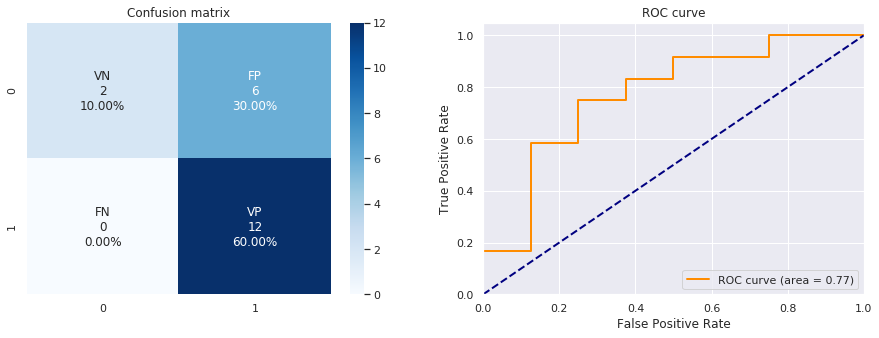

In [22]:
print('Logistic Regression unbalanced')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)


Naive-Bayes classifier unbalanced
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.67      1.00      0.80        12

    accuracy                           0.70        20
   macro avg       0.83      0.62      0.60        20
weighted avg       0.80      0.70      0.64        20

AUC:  0.8958333333333333


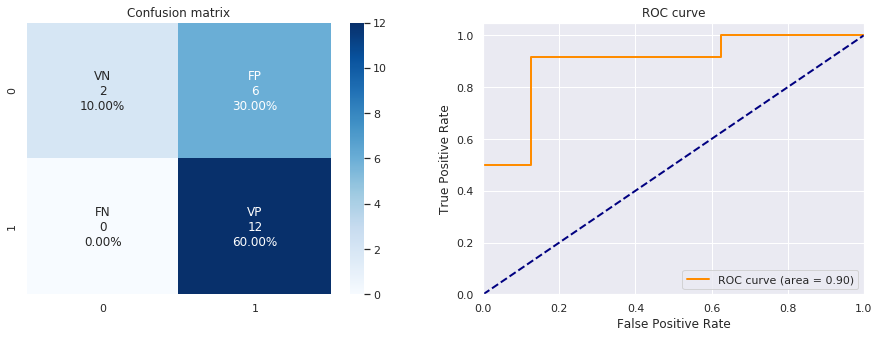

In [23]:
print('Naive-Bayes classifier unbalanced')
naiveBayes = BernoulliNB().fit(X_train, y_train)
y_pred = naiveBayes.predict(X_test)
y_prob = naiveBayes.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [24]:
scenario1_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
scenario1_metrics

,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.7,0.833333,0.625,0.6,0.770833
1,naive-bayes,0.7,0.833333,0.625,0.6,0.895833


### Scenario 1.1: scenario 1 with oversampling

In [25]:
#metrics
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

In [26]:
#oversampling with SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train.shape

(376, 2411)

logistic regression after oversampling
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.71      0.83      0.77        12

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20

AUC:  0.7708333333333333


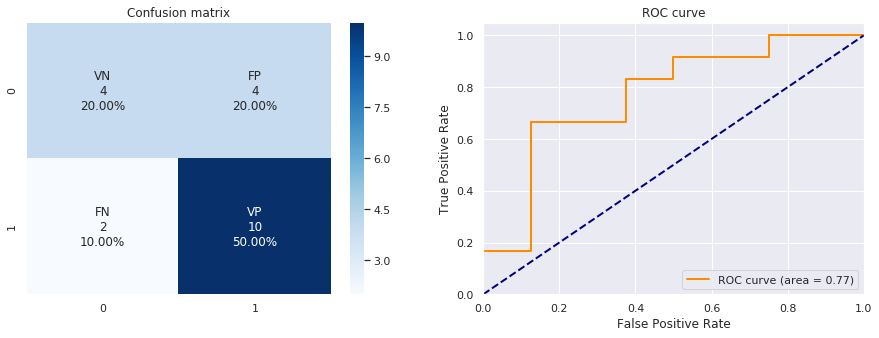

In [27]:
print('logistic regression after oversampling')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#y_pred = 1 - y_pred ###wtf????
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

SVM linear with SGD training
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.79      0.92      0.85        12

    accuracy                           0.80        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.80      0.80      0.79        20



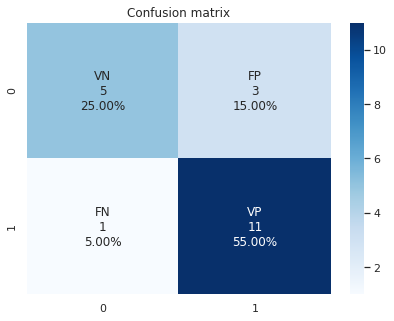

In [28]:
print('SVM linear with SGD training')
sgd = SGDClassifier().fit(X_train, y_train)
y_pred = sgd.predict(X_test)
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Naive-Bayes classifier for multivariate Bernoulli models
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.71      1.00      0.83        12

    accuracy                           0.75        20
   macro avg       0.85      0.69      0.69        20
weighted avg       0.82      0.75      0.71        20

AUC:  0.8854166666666667


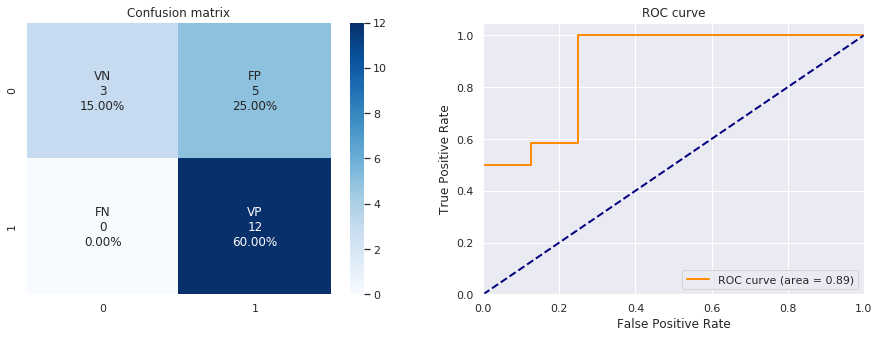

In [29]:
print('Naive-Bayes classifier for multivariate Bernoulli models')
naiveBayes = BernoulliNB().fit(X_train, y_train)
y_pred = naiveBayes.predict(X_test)
y_prob = naiveBayes.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [30]:
scenario1_1_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
scenario1_1_metrics

,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.70,0.690476,0.666667,0.67033,0.770833
1,svm,0.80,0.809524,0.770833,0.78022,0.000000
2,naive-bayes,0.75,0.852941,0.687500,0.68652,0.885417


### Scenario 2: evaluating models trained with Twitter data in WhatsApp data
Our hypothesis is that the models will NOT be able to generalize.

In [31]:
#metrics
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

In [32]:
#remove repeated messages
whatsapp = whatsapp.drop_duplicates(subset=['text'])
y = whatsapp['misinformation']
sentences = whatsapp['text']

#train-test split
sentences_train_wpp, sentences_test_wpp, y_train_wpp, y_test_wpp = train_test_split(sentences, y, test_size=0.33, 
                                                                    stratify = y, random_state=42)
#tf-idf input
X_test_wpp = vectorizer.transform(sentences_test_wpp)
X_test_wpp.shape

(37767, 2411)

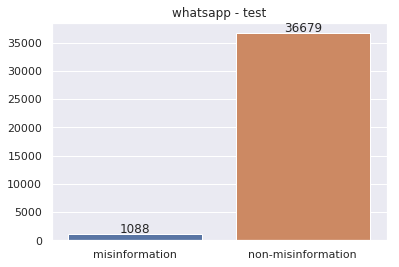

In [33]:
pos_mask = y_test_wpp == 1 
pos = y_test_wpp[pos_mask]
neg_mask = y_test_wpp == 0 
neg = y_test_wpp[neg_mask]
#print('fakes: ', pos.shape)
#print('non-fakes: ', neg.shape)
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']

plt.title('whatsapp - test')
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

Logistic Regression trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.97      0.10      0.17     36679
           1       0.03      0.90      0.06      1088

    accuracy                           0.12     37767
   macro avg       0.50      0.50      0.11     37767
weighted avg       0.94      0.12      0.17     37767

AUC:  0.5265105388682096


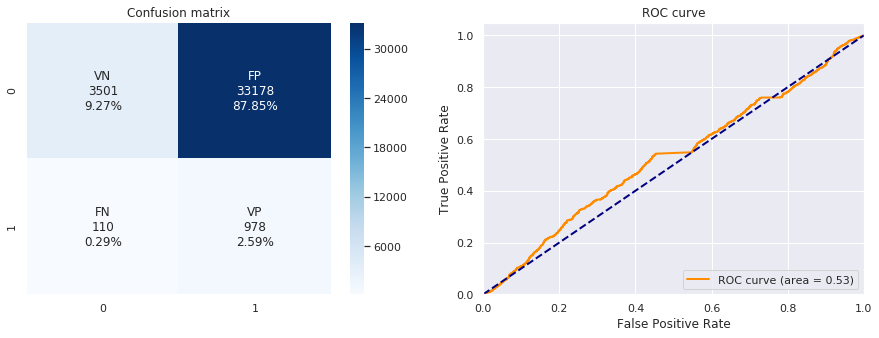

In [34]:
print('Logistic Regression trained with twitter and evaluated in WhatsApp')
y_pred = logreg.predict(X_test_wpp)
y_prob = logreg.predict_proba(X_test_wpp)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

SVM linear trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.98      0.12      0.21     36679
           1       0.03      0.91      0.06      1088

    accuracy                           0.14     37767
   macro avg       0.50      0.51      0.13     37767
weighted avg       0.95      0.14      0.20     37767



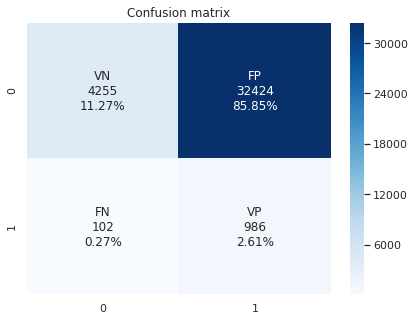

In [35]:
#svm
print('SVM linear trained with twitter and evaluated in WhatsApp')
y_pred = sgd.predict(X_test_wpp)
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred)

model.append('svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Naive-Bayes trained with twitter and evaluated in WhatsApp
              precision    recall  f1-score   support

           0       0.91      0.01      0.02     36679
           1       0.03      0.97      0.05      1088

    accuracy                           0.04     37767
   macro avg       0.47      0.49      0.04     37767
weighted avg       0.88      0.04      0.02     37767

AUC:  0.5472054703925792


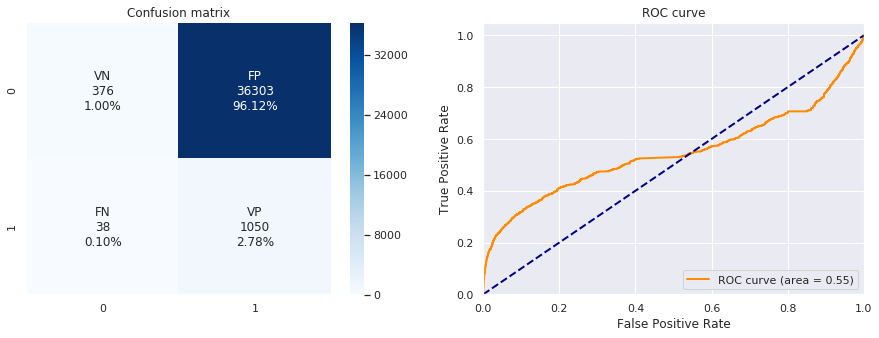

In [36]:
#svm
print('Naive-Bayes trained with twitter and evaluated in WhatsApp')
y_pred = naiveBayes.predict(X_test_wpp)
y_prob = naiveBayes.predict_proba(X_test_wpp)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob)

model.append('naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [37]:
scenario2_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
scenario2_metrics

,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.118596,0.499085,0.497173,0.114644,0.526511
1,svm,0.138772,0.503051,0.511128,0.132271,0.000000
2,naive-bayes,0.037758,0.468161,0.487662,0.037451,0.547205


### Scenario 3: training and evaluating models with WhatsApp data

In [38]:
#metrics
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

In [39]:
X_train_wpp = vectorizer.fit_transform(sentences_train_wpp)
X_test_wpp = vectorizer.transform(sentences_test_wpp)
print(X_train_wpp.shape)
print(X_test_wpp.shape)
#oversampling
X_train_wpp, y_train_wpp = sm.fit_resample(X_train_wpp, y_train_wpp)
print(X_train_wpp.shape)

(76678, 67713)
(37767, 67713)
(148940, 67713)


Logistic Regression trained and tested with WhatsApp data


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.96      0.97     36679
           1       0.34      0.72      0.46      1088

    accuracy                           0.95     37767
   macro avg       0.66      0.84      0.72     37767
weighted avg       0.97      0.95      0.96     37767

AUC:  0.9396066359898194


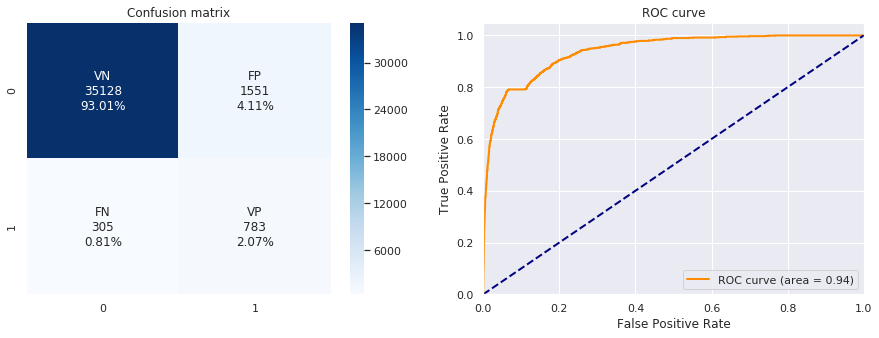

In [40]:
print('Logistic Regression trained and tested with WhatsApp data')
logreg_wpp = LogisticRegression().fit(X_train_wpp, y_train_wpp)
y_pred = logreg_wpp.predict(X_test_wpp)
y_prob = logreg_wpp.predict_proba(X_test_wpp)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

SVM linear trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     36679
           1       0.18      0.77      0.29      1088

    accuracy                           0.89     37767
   macro avg       0.58      0.83      0.61     37767
weighted avg       0.97      0.89      0.92     37767



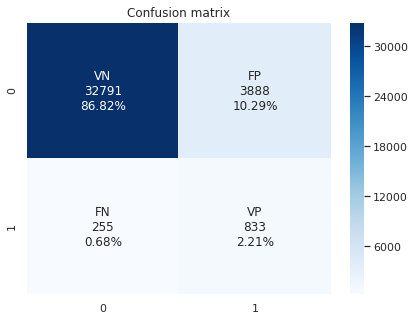

In [41]:
print('SVM linear trained and tested with WhatsApp data')
sgd = SGDClassifier().fit(X_train_wpp, y_train_wpp)
y_pred = sgd.predict(X_test_wpp)
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred)

model.append('svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Naive-Bayes trained and tested with WhatsApp data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     36679
           1       0.37      0.35      0.36      1088

    accuracy                           0.96     37767
   macro avg       0.68      0.67      0.67     37767
weighted avg       0.96      0.96      0.96     37767

AUC:  0.9097919820685982


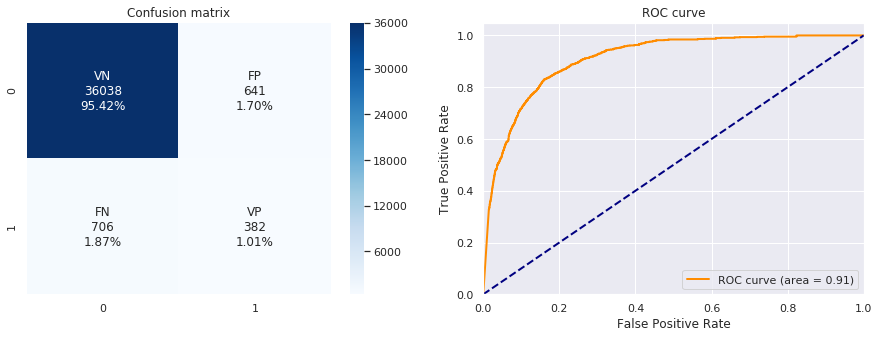

In [42]:
print('Naive-Bayes trained and tested with WhatsApp data')
naiveBayes = BernoulliNB().fit(X_train_wpp, y_train_wpp)
y_pred = naiveBayes.predict(X_test_wpp)
y_prob = naiveBayes.predict_proba(X_test_wpp)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test_wpp, y_pred, y_prob)

model.append('naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [43]:
scenario3_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
scenario3_metrics

,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.950857,0.663434,0.838692,0.715945,0.939607
1,svm,0.890301,0.584365,0.829812,0.613689,0.000000
2,naive-bayes,0.964334,0.677099,0.666814,0.671784,0.909792


# Comparation between scenarios

In [44]:
print('Scenario 1: trained and evaluated with Twitter')
scenario1_1_metrics

Scenario 1: trained and evaluated with Twitter


,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.70,0.690476,0.666667,0.67033,0.770833
1,svm,0.80,0.809524,0.770833,0.78022,0.000000
2,naive-bayes,0.75,0.852941,0.687500,0.68652,0.885417


In [45]:
print('Scenario 2: trained with Twitter and evaluated in WhatsApp')
scenario2_metrics

Scenario 2: trained with Twitter and evaluated in WhatsApp


,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.118596,0.499085,0.497173,0.114644,0.526511
1,svm,0.138772,0.503051,0.511128,0.132271,0.000000
2,naive-bayes,0.037758,0.468161,0.487662,0.037451,0.547205


In [46]:
print('Scenario 3: trained and evaluated with WhatsApp')
scenario3_metrics

Scenario 3: trained and evaluated with WhatsApp


,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.950857,0.663434,0.838692,0.715945,0.939607
1,svm,0.890301,0.584365,0.829812,0.613689,0.000000
2,naive-bayes,0.964334,0.677099,0.666814,0.671784,0.909792


In [47]:
df_metrics = pd.concat([scenario1_1_metrics, scenario2_metrics, scenario3_metrics])
df_metrics['scenario'] = ['1']*3 + ['2']*3 + ['3']*3
df_metrics

,model,accuracy,precision,recall,f1 score,auc score,scenario
0,logistic regression,0.700000,0.690476,0.666667,0.670330,0.770833,1
1,svm,0.800000,0.809524,0.770833,0.780220,0.000000,1
2,naive-bayes,0.750000,0.852941,0.687500,0.686520,0.885417,1
0,logistic regression,0.118596,0.499085,0.497173,0.114644,0.526511,2
1,svm,0.138772,0.503051,0.511128,0.132271,0.000000,2
2,naive-bayes,0.037758,0.468161,0.487662,0.037451,0.547205,2
0,logistic regression,0.950857,0.663434,0.838692,0.715945,0.939607,3
1,svm,0.890301,0.584365,0.829812,0.613689,0.000000,3
2,naive-bayes,0.964334,0.677099,0.666814,0.671784,0.909792,3


In [49]:
df_metrics.to_csv('results/2018/compare_corpora.csv', index = False)

# Conclusion
Under the same circunstances, the models perform better over WhatsApp data when trained with WhatsApp data, justifying the necessity of this corpus, since the tasks are very different.
### NEXT STEPS
Train and evaluate better models with WhatsApp Data